In [1]:
# load and clean-up data
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric
 
# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]
 
# load all data
dataset = read_csv('data/Train_Sample_WInd_Data.csv', header=0, low_memory=False, infer_datetime_format=True, parse_dates=['DateTime'], index_col=['DateTime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# save updated dataset
dataset.to_csv('NIWE_Data.csv')

In [4]:
# resample minute data to total for each day
from pandas import read_csv
# load the new file
dataset = read_csv('NIWE_Data.csv', header=0, infer_datetime_format=True, parse_dates=['DateTime'], index_col=['DateTime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('NIWE_Data_days.csv')

(523, 2)
            WindSpeed  PowerGenerated
DateTime                             
2017-01-01  584.34071       3300800.0
2017-01-02  681.31899       4666640.0
2017-01-03  634.52317       2787200.0
2017-01-04  464.19520        853360.0
2017-01-05  559.18705       1232880.0


In [2]:

# split into standard weeks
from numpy import split
from numpy import array
from pandas import read_csv
 
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-332], data[-328:-6]
    print(len(train))
    print(len(test))
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test
 
# load the new file
dataset = read_csv('NIWE_Data_days.csv', header=0, infer_datetime_format=True, parse_dates=['DateTime'], index_col=['DateTime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

190
322


ValueError: array split does not result in an equal division

In [3]:
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [37]:

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

[[  45.27662    700.01751    491.68689    454.261215   611.19635
   717.52583    811.51503  ]
 [ 793.37293    509.34942    646.26346    690.17696    671.63297
   597.31614    476.509883 ]
 [ 596.03005    522.18047    405.14328    427.93728    592.45948
   603.11411    671.42848  ]
 [ 593.05356    577.5366     831.08295    803.78124    512.07824
   623.01174    562.09719  ]
 [ 415.05022    650.92462    468.02556    433.37893    461.89888
   730.99757    743.54252  ]
 [ 772.25685    709.18994    624.47133    690.57485    700.53615
   717.36598    525.70905  ]
 [ 651.40915    801.25446    674.76347    623.72148    449.337403
   639.92069    733.36949  ]
 [ 649.75105    708.68562    769.28418    595.84658    443.734823
   529.02446    372.95691  ]
 [ 619.173297   524.99705    746.65128    786.6006     531.245003
   549.19122    531.1805   ]
 [ 582.8255     650.95695    446.250616   544.82387    494.953144
   547.03576    563.59917  ]
 [   0.           0.           0.         509.54713    5

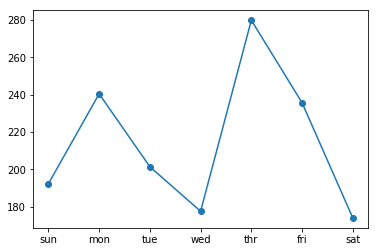

In [39]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
 
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-332], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)
 
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    print(test[:, :, 0])
    print(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores
 
# load the new file
dataset = read_csv('NIWE_Data_days.csv', header=0, infer_datetime_format=True, parse_dates=['DateTime'], index_col=['DateTime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()